#### Imports

In [1]:
import io
from itertools import combinations
from pprint import pprint as pp
import boto3, re, sys, math, json, os, sagemaker, urllib.request
from sagemaker import get_execution_role
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.display import display
from time import gmtime, strftime
from sagemaker.predictor import csv_serializer
import sagemaker
from sagemaker.serializers import CSVSerializer

# sklearn ~ statistical and analytical
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import cohen_kappa_score as kappa
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.sklearn.estimator import SKLearn

!pip install langdetect
!pip install textblob
# language and string related
import langdetect 
import re
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from textblob import TextBlob

[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#### SageMaker Parameters

In [2]:
role = get_execution_role()
my_region = boto3.session.Session().region_name
prefix = 'sagemaker'
print(f"Region: {my_region}\nRole: {role}")

Region: us-east-2
Role: arn:aws:iam::482117536264:role/service-role/AmazonSageMaker-ExecutionRole-20211128T120734


#### s3 Bucket Setup here

In [3]:
bucket_name = 'a20470263-bdt'
s3 = boto3.resource('s3')

In [4]:
try:
  bucket = s3.Bucket(bucket_name)
except Exception as e:
  print('Bucket load error: ',e)

# Part 1.

Generate File-list from the Bucket here:

In [5]:
file_list = []
for o in bucket.objects.filter(Prefix="raw_dataset/"):
    file_list.append(o.key)
file_list.remove('raw_dataset/')
pp(file_list)

['raw_dataset/change.org_stance/change.org_stance_0.csv',
 'raw_dataset/change.org_stance/change.org_stance_1.csv',
 'raw_dataset/change.org_stance/change.org_stance_2.csv',
 'raw_dataset/change.org_stance/change.org_stance_3.csv',
 'raw_dataset/change.org_stance/change.org_stance_4.csv',
 'raw_dataset/nyt_stance/nyt_stance_0.csv',
 'raw_dataset/nyt_stance/nyt_stance_1.csv',
 'raw_dataset/nyt_stance/nyt_stance_2.csv']


Import a file as Dataframe:

As well as replace Nan values with 'missing'

In [6]:
def get_data(key):
    file = bucket.Object(key).get()
    df = pd.read_csv(io.BytesIO(file['Body'].read()))
    
    ### Pre-Processing to replace Nan values with 'missing'
    df.fillna("missing", inplace = True)
    return df

Function to generate Cohen-Kappa scores for the individual dataframes:

In [7]:
def generate_scores(df):
    scores  = dict()

    # Make a list of all annotators
    annotators = df.columns[1:]
    
    # Make Combinations of annotators 
    combination = [comb for comb in combinations(annotators, 2)]

    # Find Cohen Kappa Score for each annotator
    for annotator in annotators:
        count = 0
        score = 0
        for comb in combination:
            if annotator in comb:
                count += 1
                score += kappa(df[comb[0]], df[comb[1]])
        scores[annotator] = score/count
    
    return scores

Function to score all the files:

In [8]:
def kappa_scores():

    kappa_scores = dict()

    # Make a dictionary including the Cohen Kappa Scores
    for key in file_list:
        df = get_data(key)
        scores = generate_scores(df)
        kappa_scores[key] = scores

    return kappa_scores

Now let's score all the documents and print the scores.

In [9]:
kappa_scores = kappa_scores()

# clear enviroment
del(file_list)

pp(kappa_scores)

{'raw_dataset/change.org_stance/change.org_stance_0.csv': {'annotation_27': 0.5032793858401802,
                                                           'annotation_28': 0.49463342800971427,
                                                           'annotation_29': 0.5276606620317315,
                                                           'annotation_30': 0.5145702455534705},
 'raw_dataset/change.org_stance/change.org_stance_1.csv': {'annotation_47': -0.008552173274344432,
                                                           'annotation_70': 0.3688930890135748,
                                                           'annotation_72': 0.4067923401526055,
                                                           'annotation_79': 0.3289185347006164,
                                                           'annotation_80': 0.30967719672101673},
 'raw_dataset/change.org_stance/change.org_stance_2.csv': {'annotation_21': 0.48319250404607295,
                                

A function to drop annotators which have a __Cohen Kappa Score < 0.2__ from the output of part one.

In [10]:
def get_reliable_annotators(scores):
    reliable_scores = dict()

    # Drop annotator if below 0.2
    for annotator in scores:
        if scores.get(annotator) >= 0.2:
            reliable_scores[annotator] = scores[annotator]

    return reliable_scores

A function to decide the final label for each of the text (rows) in the dataset. This is a label voting based decision making. Where ever there is a tie, label group having a higher average Cohen Kappa scores is selected as the final label. Since there is a tie, count of involved individual labels is same, and thus the total sum of Kappa scores for both the labels can be directly compared without dividing them by their counts to get the same answer.

In [11]:
def generate_final_labels(reliable_scores,df):
    
    annotators = []
    vote = []
    
    # Make a list of reliable annotators
    for annotator in reliable_scores:
        annotators.append(annotator)

    # At each row
    for _, row in df.iterrows():
    
        pro = 0
        pro_score = 0
        anti = 0
        anti_score = 0
        unclear = 0
        unclear_score = 0

        RE_PRO = re.compile(r'pro-mitigation')
        RE_UN = re.compile(r'unclear')

        # Make a count of labels and their kappa scores
        for annotator in annotators:
            if RE_PRO.search(row[annotator]):
                pro += 1
                pro_score += reliable_scores[annotator]
            elif  RE_UN.search(row[annotator]):
                unclear += 1
                unclear_score += reliable_scores[annotator]
            else:
                anti += 1
                anti_score += reliable_scores[annotator]

        # Decide which label to give based on count and average kappa score
        if (pro > anti) and (pro > unclear):
            vote.append("pro-mitigation")
        elif (unclear > anti) and (unclear > pro):
            vote.append("unclear")
        elif (anti > pro) and (anti > unclear):
            vote.append("anti-mitigation")
        else:
            
            # Special Case where 2 labels have a tie
            if (pro == anti) and (pro_score > anti_score) and (pro != unclear):
                vote.append("pro-mitigation")
            elif (pro == unclear) and (pro_score > unclear_score) and (pro != anti):
                vote.append("pro-mitigation")
            elif (anti == pro) and (anti_score > pro_score) and (anti != unclear):
                vote.append("anti-mitigation")
            elif (anti == unclear) and (anti_score > unclear_score) and (anti != pro):
                vote.append("anti-mitigation")
            elif (unclear == pro) and (unclear_score > pro_score) and (unclear != anti):
                vote.append("unclear")
            elif (unclear == anti) and (unclear_score > anti_score) and (unclear != pro):
                vote.append("unclear")
            else:
                
                # Special-Special Case where all 3 labels have a tie
                if (anti_score > unclear_score) and (anti_score > pro_score):
                    vote.append("anti-mitigation")
                elif (pro_score > unclear_score) and (pro_score > anti_score):
                    vote.append("pro-mitigation")
                else:
                    vote.append("unclear")
    
    # Return a new Dataframe with just text and label
    final_df = df[['text']].copy()
    final_df['label'] = vote
    return final_df

In [12]:
def make_final_df(kappa_scores):
    
    # Make a blank DF
    output = pd.DataFrame(columns=['text', 'label'])

    # At each file
    for key in kappa_scores:
        
        # keep only reliable annotators
        reliable_scores = get_reliable_annotators(kappa_scores[key])
        print(f"Reliable annotators in {key}")
        pp(reliable_scores)

        # get the corresponding dataset 
        df = get_data(key)

        # give final labels to the file and append to output
        output = output.append(generate_final_labels(reliable_scores, df), ignore_index=True)

    return output

In [13]:
dataset = make_final_df(kappa_scores)

Reliable annotators in raw_dataset/change.org_stance/change.org_stance_0.csv
{'annotation_27': 0.5032793858401802,
 'annotation_28': 0.49463342800971427,
 'annotation_29': 0.5276606620317315,
 'annotation_30': 0.5145702455534705}
Reliable annotators in raw_dataset/change.org_stance/change.org_stance_1.csv
{'annotation_70': 0.3688930890135748,
 'annotation_72': 0.4067923401526055,
 'annotation_79': 0.3289185347006164,
 'annotation_80': 0.30967719672101673}
Reliable annotators in raw_dataset/change.org_stance/change.org_stance_2.csv
{'annotation_21': 0.48319250404607295,
 'annotation_23': 0.46708670683466663,
 'annotation_25': 0.4581048880702892,
 'annotation_77': 0.4807285389202223}
Reliable annotators in raw_dataset/change.org_stance/change.org_stance_3.csv
{'annotation_88': 0.43216821649980325,
 'annotation_89': 0.38854883684022506,
 'annotation_90': 0.40958486212809087,
 'annotation_92': 0.43285730035790787}
Reliable annotators in raw_dataset/change.org_stance/change.org_stance_4.csv

Final Dataset looks as follows:

In [14]:
dataset.head(10)

,text,label
0,Postpone CBSE Board Exams,unclear
1,Pay rise for paramedics and nurses,unclear
2,Too Soon To Open Georgia!,pro-mitigation
3,Request to reconsider DPS Ruby Park school tui...,pro-mitigation
4,Covid-19 Aesthetics / Salon / Massage Industry...,unclear
5,Pause classes and encourage online classes to ...,pro-mitigation
6,Allow Salons to Operate with New Health Guidel...,pro-mitigation
7,Open Letter to the AAMC Concerning the Medical...,unclear
8,Canadian Nurses Deserve Hazard Pay For Pandemics,pro-mitigation
9,Maharashtra demands Resignation from Uddhav Th...,unclear


In [15]:
dataset.shape

(2313, 2)

In [16]:
del(kappa_scores)

# Part 2.


## 1. Make Partitions
Let's explore the data before making partitions to better understand the distribution of the classes.

In [17]:
print(f"Class distribution is:\n{dataset['label'].value_counts()/dataset.shape[0]}")

Class distribution is:
unclear            0.455685
pro-mitigation     0.442283
anti-mitigation    0.102032
Name: label, dtype: float64


Takeaway: Focusing on the dataset's distribution since that will be used to train the model, it is observed that:

a majority (45%) records belong to the unclear class.
followed by (at 44%) pro-mitigation class.
This is not a balanced distribution, and thus, might give us a bad model.

In [18]:
x_train, x_test, y_train, y_test = train_test_split(dataset["text"], dataset["label"], test_size=0.3, stratify=dataset["label"], shuffle=True)


We have split the dataset into train and test using the stratify parameter which keeps the samples similar to the actual dataset's distribution.

Let's explore the train and test set's distribution.

In [19]:
print(f"Class distribution for TRAIN SET is:\n{y_train.value_counts()/y_train.shape[0]}")
print(f"\nClass distribution for TEST SET is:\n{y_test.value_counts()/y_test.shape[0]}")

Class distribution for TRAIN SET is:
unclear            0.455837
pro-mitigation     0.442248
anti-mitigation    0.101915
Name: label, dtype: float64

Class distribution for TEST SET is:
unclear            0.455331
pro-mitigation     0.442363
anti-mitigation    0.102305
Name: label, dtype: float64


Now that we have similar distributions in the Train and Test sets, we can create our first model using these.

## 2. Problems with Dataset:

Let's create a simple bag of words to find out the problems with our dataset so that we can preprocess the data accordingly.

I have used Count Vectorizer Class from sklearn package's Textual Feature Extraction module to create bag-of-words.

In [20]:
vectorizer = CountVectorizer()

I'll create (fit) a bag-of-words on the training set only and use this bag-of-words to transfrom test sets.

In [21]:
bow_train = vectorizer.fit_transform(x_train)
bow_test = vectorizer.transform(x_test)

let's see the word bags that are being created.

In [22]:
word_bags = vectorizer.get_feature_names()
del(vectorizer)
print(f"There are a total of {len(word_bags)} word bags, and some of them are:")
word_bags[:15]

There are a total of 6961 word bags, and some of them are:


['00',
 '000',
 '021',
 '03553',
 '04',
 '09',
 '10',
 '100',
 '101',
 '102',
 '1080',
 '10hrs',
 '10th',
 '11',
 '110']

Multiple problems with the words can be immidiately noticed.

PROBLEMS:

existance of different canonical forms of the same stem word. Let's take the word 'act' as an example.

In [23]:
# get index number of word act from the list
act_index = word_bags.index('act')

# display the canonical forms
word_bags[act_index:act_index+7]

['act', 'acted', 'acting', 'action', 'actions', 'active', 'actively']

existance of different language or symbols that do not belong to English language.

In [24]:
word_bags[-5:]

['대책', '도산', '레스토랑', '방지', '일본']

loss of context since words are being converted to lower case. Example: WHO and who go in the same bucket, definitely one (WHO-World Health Organization) is more important than the other with respect to Covid-19 and the context of the texts.

In [25]:
# get index number of word act from the list
who_index = word_bags.index('who')
word_bags[who_index:who_index+2]

['who', 'whole']


Other than these problems one obvious problem,


or rather, an expected occuring in any Natural Language task is the introduction of new words i.e. words that weren't part of the Train Dataset but appear in the Test Dataset. These words were not recorded as a word bag and thus would not contribute to the classification process. Not much can be done about this.

Let's see how many new words our classifiers in of this report will be facing.

In [26]:
# Create a temparay vectorizer to find newly appearing words
temp_vectorizer = CountVectorizer()
temp_vectorizer.fit_transform(x_test)
temp_word_bags = temp_vectorizer.get_feature_names()

# Compare the bag of words to find newly occuring words.
# using XOR operator to Zero out the common words, leaving unique ones.
new_words = list(set(word_bags) ^ set(temp_word_bags))

# Display the results
print(f"There are a total of {len(new_words)} new words that the classifier faces, some of them are:")
new_words[:20]


There are a total of 5709 new words that the classifier faces, some of them are:


['prevented',
 'conclude',
 'hedge',
 'legislate',
 'cardiac',
 'kf94',
 'whining',
 'formula',
 'suggesting',
 'breaker',
 'positions',
 'bihar',
 'replacements',
 'statistical',
 'happening',
 'penalty',
 'wrestling',
 'fake',
 'picnic',
 'round']

In [27]:
del(temp_vectorizer, temp_word_bags, new_words)

## 3. Pre-Processing

Let's get rid of some of the problems we just saw:

1. We will filter the dataset's to just keep english language texts
2. lower case the words, even though we might be losing some context.
3. Clean to remove punctuations
4. tokenize words
5. then convert each word to their lemma form to get consistency.
6. remove stopwords

In [28]:
def preprocess(x):
    
    # if text is english then preprocess else return None
    try:
        if langdetect.detect(x) == 'en':
            
            # cleaning to keep words
            x = re.sub(r'[^\w\s]', '', str(x).lower().strip())
            
            # cleaning to remove special chars from english
            x = re.sub('[^A-Za-z0-9]', ' ', x)
            
            # tokenize
            tokenized_x = x.split()
           
            # remove stopwords
            for word in tokenized_x:
                if word in stopwords.words('english'):
                    tokenized_x.remove(word)

            # lemmatize
            for i, w in enumerate(tokenized_x):
                tokenized_x[i] = WordNetLemmatizer().lemmatize(w)
            
            # join sentence again
            x = " ".join(tokenized_x)
            
            # return filtered sentence
            return x
        
    
    # if text is not detectable return none
    except:
        pass

Now let's preprocess our dataset:

We concat the X and Y, Preprocess on X, drop Nan records then split into X and Y again.

In [29]:
# training set
train_set = pd.concat([x_train, y_train], axis=1)
train_set['text'] = train_set['text'].apply(preprocess)
train_set.dropna(inplace=True)
x_train, y_train = train_set['text'], train_set['label']
del(train_set)

# testing set
test_set = pd.concat([x_test, y_test], axis=1)
test_set['text'] = test_set['text'].apply(preprocess)
test_set.dropna(inplace=True)
x_test, y_test = test_set['text'], test_set['label']
del(test_set)

In [30]:
# processed dataset
print(x_train.shape)
x_train.head(15)

(1499,)


537                      support safe school saskatchewan
1414    petition nsw year 12 student hold graduation a...
1420                 covid outbreak close devonshire mall
823         allow ontario young athlete safe return sport
1812    scientist agreed urged localized approach obvi...
10      bc health mandatory mask usage across bc share...
2139    read pfizer german company biontech become fir...
1848    economy not going rebound properly without com...
1820    stimulus payment go the business employee them...
878     support fair pay nzs aged care nurse petition ...
1972    am libertarian most issue not one 40 year care...
53      fate amazonia it guardian linked ours europe m...
140                          act temp la vega rent freeze
548                        raise awareness defeat covid19
1010    request make gmu fall 2020 class passfail opti...
Name: text, dtype: object

Create Bag of Words:

In [31]:
vectorizer = CountVectorizer()
bow_train = vectorizer.fit_transform(x_train)
bow_test = vectorizer.transform(x_test)
del(vectorizer)

## 4. Feature Engineering

We will experiment with a few features here only then select the best ones.

### 1. Sentiment Analysis:
In this we assign a score to the text based on the sentiment of the text using TextBlob package.

In [32]:
def ScoreSentiment(x):
    return TextBlob(x).sentiment.polarity

Let's make a crosstable for the sentiments we found on the training dataset.

In [33]:
sentiment_check = x_train.apply(ScoreSentiment)
ct_sentiment = pd.crosstab(sentiment_check, y_train)
ct_sentiment

label,anti-mitigation,pro-mitigation,unclear
text,,,
-0.800000,0,0,2
-0.800000,1,0,0
-0.700000,0,1,1
-0.700000,0,1,0
-0.633333,0,1,0
...,...,...,...
0.600000,2,0,1
0.700000,0,1,0
0.700000,0,3,6


This crosstable doesn't give much information directly, but we can transform this table in a way to get information from it.

What I will do is multiply the sentiment score with the frequency for each label and save it in a new column with absolute score. So this will give us the actual sentiment score to a label.

In [34]:
ct_sentiment['anti-mitigation-abs'] = ct_sentiment['anti-mitigation'] * ct_sentiment.index
ct_sentiment['pro-mitigation-abs'] = ct_sentiment['pro-mitigation'] * ct_sentiment.index
ct_sentiment['unclear-abs'] = ct_sentiment['unclear'] * ct_sentiment.index
ct_sentiment

label,anti-mitigation,pro-mitigation,unclear,anti-mitigation-abs,pro-mitigation-abs,unclear-abs
text,,,,,,
-0.800000,0,0,2,-0.0,-0.000000,-1.6
-0.800000,1,0,0,-0.8,-0.000000,-0.0
-0.700000,0,1,1,-0.0,-0.700000,-0.7
-0.700000,0,1,0,-0.0,-0.700000,-0.0
-0.633333,0,1,0,-0.0,-0.633333,-0.0
...,...,...,...,...,...,...
0.600000,2,0,1,1.2,0.000000,0.6
0.700000,0,1,0,0.0,0.700000,0.0
0.700000,0,3,6,0.0,2.100000,4.2


Now I can take the sum of the absolute sentiment scores for each category. Now this will be very useful as we expect opposite categories to have more steep sentiment score so there should be a difference.

In [35]:
# sum of absolute score for anti-mitigation
ct_sentiment['anti-mitigation-abs'].sum()

7.0854420006102075

In [36]:
# sum of absolute score for unclear
ct_sentiment['unclear-abs'].sum()

15.104403537368139

In [37]:
# sum of absolute score for pro-mitigation
ct_sentiment['pro-mitigation-abs'].sum()

38.781983928427856

This is good as there is a gap between the scores from opposite labels, so we will use the sentiment score as a feature in our model.

In [38]:
del(sentiment_check, ct_sentiment)

### 2. Finding significant Bi-grams:

Here I'll first find the most frequently occuring Bi-grams:

In [39]:
# make a list of tokens
list_of_tokens = word_tokenize(x_train.str.cat(sep=" "))
# make bigrams and count frequency
dic_words_freq = nltk.FreqDist(nltk.ngrams(list_of_tokens, 2))
# convert into DataFrame to visualize
bi_grams = pd.DataFrame(dic_words_freq.most_common(), columns=["Word","Freq"])

We'll now find the most relevant Bi-grams from the top 25 pairs I found.

In [40]:
bi_grams[:25]

,Word,Freq
0,"(get, vaccinated)",63
1,"(wear, mask)",61
2,"(covid, 19)",46
3,"(due, covid19)",44
4,"(wearing, mask)",44
5,"(the, vaccine)",43
6,"(public, health)",40
7,"(covid19, pandemic)",32
8,"(dont, want)",30
9,"(fully, vaccinated)",28


Significant Bi-grams:

wear mask, get vaccinated, spread covid19, close school, prevent covid19.

functions to find these bi-grams are listed at the end of feature engineering.

Most relevant Bi-grams are signified on the basis of information gain. (one example given below)

In [41]:
def bi_WearMask(x):
    return int( bool( re.match(fr'.*wear mask',x) ))

This function returns 1 if the bigram exists in the sentence.

I'll find the presence and then make a crosstable of this.

In [42]:
wf = x_train.apply(bi_WearMask)
pd.crosstab(wf,y_train)

label,anti-mitigation,pro-mitigation,unclear
text,,,
0,152,652,648
1,6,35,6


As you can see, everytime this Bi-gram has occured i.e. seeing the 1 row, it is almost everytime belonging to the 'pro-mitigation' class. So this gives us high information gain. We've done similar for other Bi-grams.

In [43]:
def bi_GetVax(x):
    return int( bool( re.match(fr'.*get vaccinated',x) ))
def bi_SpreadCov(x):
    return int( bool( re.match(fr'.*spread covid19',x) ))
def bi_CloseSchool(x):
    return int( bool( re.match(fr'.*close school',x) ))
def bi_PreventCov(x):
    return int( bool( re.match(fr'.*prevent covid19',x) ))
del(wf, bi_grams, dic_words_freq, list_of_tokens)

### 3. Word Count

Gives us the count of words in the sentence.

In [44]:
# function to do wordcount
def WordCount(x):
    return len(x.split())

Let's get a word count on the training set and create a cross-table to see if we get a block with high frequency or see some patterns.

In [45]:
word_count_on_train = x_train.apply(WordCount)
pd.crosstab(word_count_on_train,y_train)

label,anti-mitigation,pro-mitigation,unclear
text,,,
1,1,1,4
2,3,4,9
3,3,14,19
4,8,24,55
5,10,35,61
...,...,...,...
166,0,0,2
169,0,0,1
170,0,0,1


There is a normal distribution pattern seen in this. Although this pattern is observed in all the three labels, we would add this feature to our bag-of-words to see if it improves the model.

In [46]:
del(word_count_on_train)

## 5. Add Engineered Features to Bag of Words

Let's add Sentiment Score first:

In [47]:
bow_train = np.insert(bow_train.todense(), bow_train.shape[1], x_train.apply(ScoreSentiment), axis=1)
bow_test = np.insert(bow_test.todense(), bow_test.shape[1], x_test.apply(ScoreSentiment), axis=1)

Next is Word Counts:

In [48]:
bow_train = np.insert(bow_train, bow_train.shape[1], x_train.apply(WordCount), axis=1)
bow_test = np.insert(bow_test, bow_test.shape[1], x_test.apply(WordCount), axis=1)

Finally for Bi-grams:

In [49]:
# For the bi-gram 'wear mask':
bow_train = np.insert(bow_train, bow_train.shape[1], x_train.apply(bi_WearMask), axis=1)
bow_test = np.insert(bow_test, bow_test.shape[1], x_test.apply(bi_WearMask), axis=1)

# For the bi-gram 'get vaccinated':
bow_train = np.insert(bow_train, bow_train.shape[1], x_train.apply(bi_GetVax), axis=1)
bow_test = np.insert(bow_test, bow_test.shape[1], x_test.apply(bi_GetVax), axis=1)

# For the bi-gram 'spread covid19':
bow_train = np.insert(bow_train, bow_train.shape[1], x_train.apply(bi_SpreadCov), axis=1)
bow_test = np.insert(bow_test, bow_test.shape[1], x_test.apply(bi_SpreadCov), axis=1)

# For the bi-gram 'close school':
bow_train = np.insert(bow_train, bow_train.shape[1], x_train.apply(bi_CloseSchool), axis=1)
bow_test = np.insert(bow_test, bow_test.shape[1], x_test.apply(bi_CloseSchool), axis=1)

# For the bi-gram 'prevent covid19':
bow_train = np.insert(bow_train, bow_train.shape[1], x_train.apply(bi_PreventCov), axis=1)
bow_test = np.insert(bow_test, bow_test.shape[1], x_test.apply(bi_PreventCov), axis=1)

## 6. Upload datasets to S3 for SageMaker to use:

In [50]:
if not os.path.exists('dataset'):
    os.mkdir('dataset')
    
train_data = pd.DataFrame(bow_train)    
train_data = pd.concat([train_data, y_train], axis=1)
train_data.dropna(inplace=True)
train_data.to_csv('dataset/train.csv', index=False, header=False)
bucket.Object(os.path.join(prefix, 'train/train.csv')).upload_file('dataset/train.csv')
s3_input_train = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/train'.format(bucket_name, prefix), content_type='csv')

test_data = pd.DataFrame(bow_test)
test_data = pd.concat([test_data, y_train], axis=1)
test_data.dropna(inplace=True)
pd.concat([test_data, y_test], axis=1).to_csv('dataset/test.csv', index=False, header=False)
bucket.Object(os.path.join(prefix, 'test/test.csv')).upload_file('dataset/test.csv')

## 7. Model Training & Evaluation:

In this section we will evaluate the models we create.

To perform evaluation, we have created the following evalutaion function (utility function) which finds the accuracy score, precision, recall, fscore and plots the confusion matrix once called. It only takes the model, true labels and predicted labels as arguments.

Precision, recall and fscore are weighted because the class labels are imbalanced.

I'll be using this function now on where-ever required

In [51]:
def evaluate(y_test, y_hat):
    ## Using Accuracy Score
    accuracy = accuracy_score(y_test, y_hat)
    print(f"Accuracy Score: {accuracy}")

    ## Using Precision, Recall and F-score
    prf = precision_recall_fscore_support(y_test, y_hat, average='weighted')
    print(f"Precision: {prf[0]}\nRecall: {prf[1]}\nF-score: {prf[2]}")

    ## Using Confusion Matric
    cmatrix = confusion_matrix(y_test, y_hat)
    # PLOT
    disp = ConfusionMatrixDisplay(cmatrix)
    disp.plot()
    plt.title("CONFUSION MATRIX")
    plt.show()

# Models

## Logistic Regression (implemented using sagemaker container)

In [53]:
from sagemaker.sklearn.estimator import SKLearn

sklearn = SKLearn(
    entry_point="train.py", framework_version="0.20.0", instance_type="ml.m5.xlarge", role=role
)

In [55]:
%%writefile train.py


import os
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.externals import joblib



if __name__ == "__main__":
    
    print("Reading input data")
    train_df = pd.read_csv(os.path.join(os.environ['SM_CHANNEL_TRAIN'], 'train.csv'), header=None, engine="python")
    X_train, y_train = train_df.iloc[:,:-1],train_df.iloc[:,-1:]

    model = LogisticRegression(class_weight="balanced", solver="lbfgs")
    print("Training LR model")
    model.fit(X_train, y_train)
    model_output_directory = os.path.join(os.environ.get('SM_MODEL_DIR'), "model.joblib")
    print("Saving model to {}".format(model_output_directory))
    joblib.dump(model, model_output_directory)

Overwriting train.py


In [56]:
sklearn.fit({'train':'s3://a20470263-bdt/sagemaker/train'})

2021-12-09 04:32:49 Starting - Starting the training job...
2021-12-09 04:33:13 Starting - Launching requested ML instancesProfilerReport-1639024369: InProgress
...
2021-12-09 04:33:41 Starting - Preparing the instances for training.........
2021-12-09 04:35:17 Downloading - Downloading input data
2021-12-09 04:35:17 Training - Downloading the training image...
2021-12-09 04:35:50 Uploading - Uploading generated training model
2021-12-09 04:35:50 Completed - Training job completed
2021-12-09 04:35:33,276 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2021-12-09 04:35:33,279 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-12-09 04:35:33,288 sagemaker_sklearn_container.training INFO     Invoking user training script.
2021-12-09 04:35:33,588 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-12-09 04:35:33,817 sagemaker-training-toolkit INFO     No GPUs detected (normal if n


### Due to cost constraint we were not able to deploy the model we created to an instance for evaluation. Infact we implemented the following models using SKlearn within this Sagemaker Jupyter Notebook without containers. 

We have reimplemented Logistic Regression for evaluation.

### Logistic Regression Classifier:

Logistic Regression Evaluation:
Accuracy Score: 0.48829953198127923
Precision: 0.4988506113203029
Recall: 0.48829953198127923
F-score: 0.4922065243633377


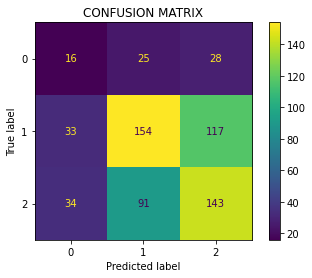

In [73]:
from sklearn.linear_model import LogisticRegression

LogisticRegression = GaussianNB()
LogisticRegression.fit(bow_train, y_train)

y_hat = LogisticRegression.predict(bow_test)

print("Logistic Regression Evaluation:")
evaluate(y_test, y_hat)

### Gaussian NB:

This model is created in notebook directly, rather 

than sagemaker's container due to cost constraint.

GaussianNB Evaluation:
Accuracy Score: 0.48829953198127923
Precision: 0.4988506113203029
Recall: 0.48829953198127923
F-score: 0.4922065243633377


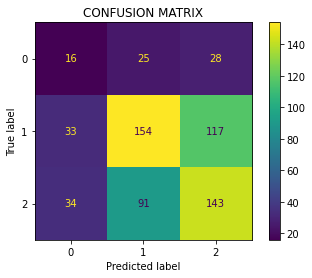

In [74]:
from sklearn.naive_bayes import GaussianNB

GaussianNBdel = GaussianNB()
GaussianNBdel.fit(bow_train, y_train)

y_hat = GaussianNBdel.predict(bow_test)

print("GaussianNB Evaluation:")
evaluate(y_test, y_hat)

### Random Forest Classifier:

Random Forest Evaluation:
Accuracy Score: 0.48829953198127923
Precision: 0.4988506113203029
Recall: 0.48829953198127923
F-score: 0.4922065243633377


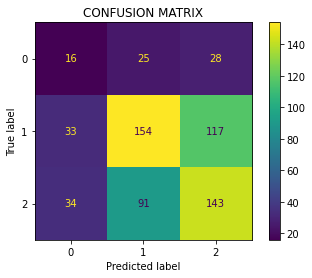

In [75]:
from sklearn.ensemble import RandomForestClassifier

RandomForestClassifier = GaussianNB()
RandomForestClassifier.fit(bow_train, y_train)

y_hat = RandomForestClassifier.predict(bow_test)

print("Random Forest Evaluation:")
evaluate(y_test, y_hat)